In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Se cargan los Features (X) generados en el notebook anterior
X_train = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/Networks_X_train.npy')
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/Networks_X_test.npy')

# Se cargan los Targets (y)
y_train_orig = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/y_train.npy')
y_test_orig = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/y_test.npy')

# Se carga el Tokenizer (necesario para saber el tamaño del vocabulario)
with open('/content/drive/MyDrive/Colab Notebooks/TFM/keras_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [2]:
# Se comprueban los tamaños de los datos cargados
print(f"Tamaño X_train: {X_train.shape}")
print(f"Tamaño X_test:  {X_test.shape}")
print(f"Tamaño y_train: {y_train_orig.shape}")
print(f"Tamaño y_train: {len(tokenizer.word_index) + 1}")

Tamaño X_train: (7842, 512)
Tamaño X_test:  (1961, 512)
Tamaño y_train: (7842,)
Tamaño y_train: 62095


In [3]:
# Las etiquetas son -1, 0, 1. Keras necesita 0, 1, 2 para 'to_categorical'.
# Se mapean sumando 1: -1 -> 0, 0 -> 1, 1 -> 2

y_train = to_categorical(y_train_orig + 1, num_classes=3)
y_test = to_categorical(y_test_orig + 1, num_classes=3)

# Se muestra un ejemplo para verificar la transformación
print(f"Etiqueta Original (ejemplo): {y_train_orig[0]}")
print(f"Etiqueta One-Hot (ejemplo):  {y_train[0]}")

Etiqueta Original (ejemplo): -1
Etiqueta One-Hot (ejemplo):  [1. 0. 0.]


In [4]:
# Se convierten las etiquetas de One-Hot a enteros simples para el cálculo
y_train_integers = np.argmax(y_train, axis=1)

# Se calculan los pesos para equilibrar
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)

# Se crea el diccionario que necesita keras
class_weights_dict = dict(enumerate(class_weights_vals))

print("Pesos de Clase Calculados:", class_weights_dict)
# Se muestra como se ha penalizado viendo que el valor de, que seria 1 es inferior a 1.

Pesos de Clase Calculados: {0: np.float64(5.280808080808081), 1: np.float64(3.2512437810945274), 2: np.float64(0.399510927709002)}


In [5]:
# Se definen los parámetros en base al Tokenizer y los datos
VOCAB_SIZE = len(tokenizer.word_index) + 1  # +1 por el token de padding
MAX_LENGTH = X_train.shape[1]
EMBEDDING_DIM = 100

def build_cnn_model():
    model = Sequential([
        # Capa de Embedding: Aprende la representación vectorial
        Embedding(input_dim=VOCAB_SIZE,
                  output_dim=EMBEDDING_DIM,
                  input_length=MAX_LENGTH),

        # Capa Convolucional (Conv1D): Detecta patrones locales
        Conv1D(filters=128, kernel_size=5, activation='relu'),

        # Global Max Pooling: Se queda con la característica más relevante
        GlobalMaxPooling1D(),

        # Capas Densas para clasificación
        Dense(64, activation='relu'),
        Dropout(0.5), # Se apagan neuronas para evitar overfitting

        # Capa de Salida: 3 clases con Softmax
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Se construye y muestra el resumen del modelo
model = build_cnn_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Se configura el EarlyStopping para detener si no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

BATCH_SIZE = 32
EPOCHS = 20

print("Iniciando Entrenamiento")
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=1
)


Iniciando Entrenamiento
Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4381 - loss: 1.1043 - val_accuracy: 0.1873 - val_loss: 1.1301
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4921 - loss: 1.0405 - val_accuracy: 0.7096 - val_loss: 0.7476
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7871 - loss: 0.7134 - val_accuracy: 0.7490 - val_loss: 0.6014
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9116 - loss: 0.3281 - val_accuracy: 0.8293 - val_loss: 0.4790
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9745 - loss: 0.1084 - val_accuracy: 0.8344 - val_loss: 0.5253
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9915 - loss: 0.0478 - val_accuracy: 0.8433 - val_loss: 0.5870
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9959 - loss: 0.0273 - val_accuracy: 0.8471 - val_loss: 0.6763


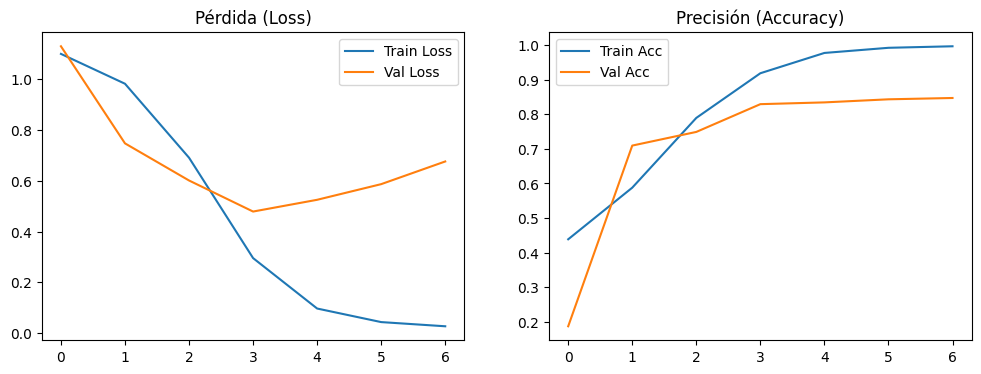

Test Accuracy: 82.15%


In [7]:
# Se muestra la pérdida y la precisión
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Precisión (Accuracy)')
plt.legend()
plt.show()

# Se evalúa el modelo con el conjunto de test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")



62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
                      precision    recall  f1-score   support

Not Recommended (-1)       0.35      0.40      0.38       124
  Mixed Feelings (0)       0.29      0.22      0.25       201
     Recommended (1)       0.91      0.93      0.92      1636

            accuracy                           0.82      1961
           macro avg       0.52      0.52      0.51      1961
        weighted avg       0.81      0.82      0.82      1961



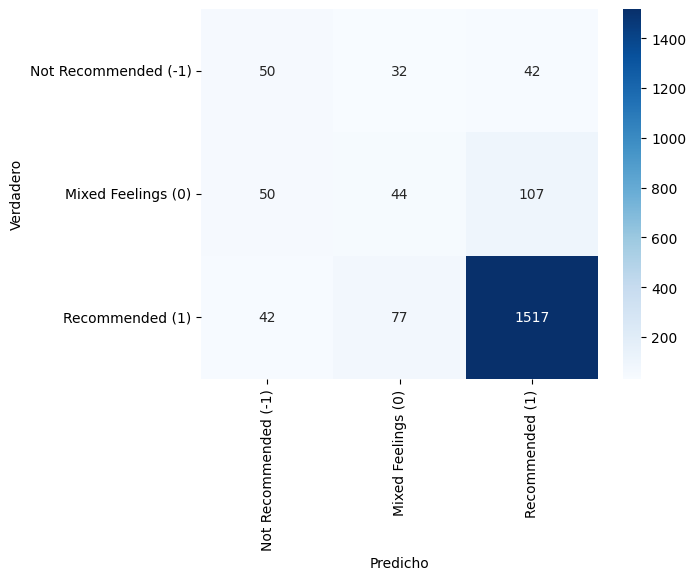

In [8]:
# Se predicen las clases
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Nombres de etiquetas originales
class_names = ['Not Recommended (-1)', 'Mixed Feelings (0)', 'Recommended (1)']

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Se muestra la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

In [9]:
# Se guarda el modelo
model.save('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_cnn_tfm.keras')
print("Modelo guardado")

Modelo guardado
